# XGBoost vs. logistic regression

I want to assess the difference in classification performance for xgboost compared to logistic regression. I will start by comparing the performances of these two models across our constituent datasets.

In [24]:
import os

import numpy as np
import pandas as pd
import duckdb
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

import xgboost as xgb
from xgboost import plot_importance
from sklearn.linear_model import LogisticRegression

In [2]:
def get_run_info(filepath):

    # Split the string at each slash to isolate each part of the path
    parts = filepath.split("/")

    # The target part is the one that contains 'params.dataset' and 'params.support_set_size'
    target = [part for part in parts if "params.dataset" in part and "params.model" in part][0]

    # Split the target part at each comma
    params = target.split(",")

    # Split each parameter at the equals sign and take the second part
    dataset = params[0].split("=")[1]
    model = params[1].split("=")[1]  # convert to int for numerical operations

    return {"model": model, "dataset": dataset}

In [4]:
INPUT_DIR = "/Users/sethhowes/Desktop/FS-Tox/multirun/2023-07-24/11-25-31"
run_dirs = [os.path.join(INPUT_DIR, run_dir) for run_dir in os.listdir(INPUT_DIR) if os.path.isdir(os.path.join(INPUT_DIR, run_dir))]
run_dirs = [f"{run_dir}/data/processed/score/*.parquet" for run_dir in run_dirs]

datasets = ["toxcast", "toxval", "nci60", "cancerrx", "prism"]

con = duckdb.connect()

dfs = []

for run_dir in run_dirs:
    info = get_run_info(run_dir)
    query = f"""
    SELECT delta_auc_pr
    FROM read_parquet('{run_dir}')
    """
    try:
        df = con.execute(query).df()
        df["model"] = info["model"]
        df["dataset"] = info["dataset"]
        dfs.append(df)
    except Exception as e:
        print(f"No data for {info['dataset']} trained with feature of {feature}")

        
# Concatenate all dataframes into one
df_final = pd.concat(dfs, ignore_index=True)

IndexError: list index out of range

In [10]:
df_final

,delta_auc_pr,model,dataset
0,0.195027,xgboost,nci60
1,0.063527,xgboost,nci60
2,0.038086,xgboost,nci60
3,-0.001549,xgboost,nci60
4,-0.012545,xgboost,nci60
...,...,...,...
3041,-0.026380,xgboost,prism
3042,0.013584,xgboost,prism
3043,-0.005274,xgboost,prism
3044,0.023219,xgboost,prism


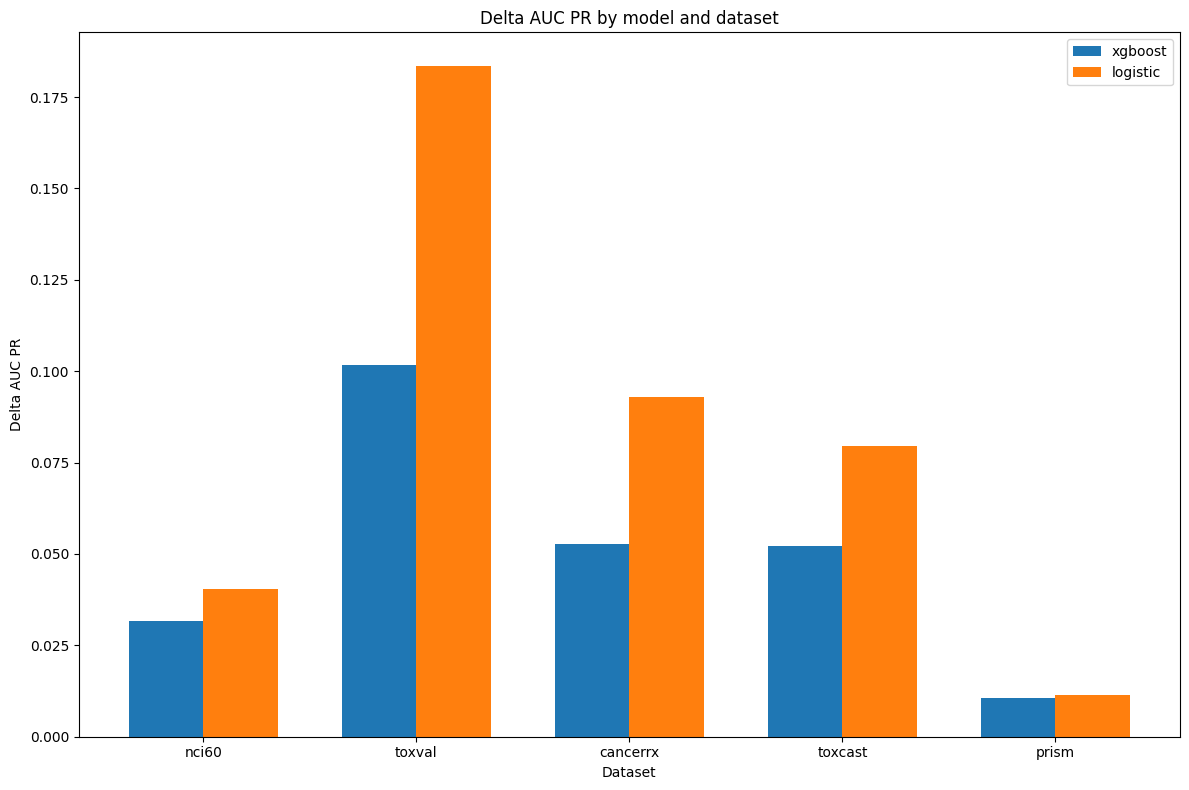

In [16]:
datasets = df_final["dataset"].unique().tolist()
models = df_final["model"].unique().tolist()
feature_width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(12, 8))

# Create an array of dataset indices for plot positioning
dataset_indices = np.arange(len(datasets))

for idx, model in enumerate(models):
    model_data = df_final[df_final["model"] == model]
    median_values = [model_data[model_data["dataset"] == dataset]["delta_auc_pr"].median() for dataset in datasets]
    rects = ax.bar(dataset_indices - feature_width/2 + idx*feature_width, median_values, feature_width, label=model)

ax.set_xlabel('Dataset')
ax.set_ylabel('Delta AUC PR')
ax.set_title('Delta AUC PR by model and dataset')
ax.set_xticks(dataset_indices)
ax.set_xticklabels(datasets)
ax.legend()

plt.tight_layout()
plt.show()

Logistic regression is clearly outperforming XGBoost across each dataset by a similar margin.

## Performance for ECFP4 vs. embeddings
I want to see whether the performance varies if we use embeddings vs. ECFP4 fingerprints.

In [8]:
def get_run_info(filepath):

    # Split the string at each slash to isolate each part of the path
    parts = filepath.split("/")

    # The target part is the one that contains 'params.dataset' and 'params.support_set_size'
    target = [part for part in parts if "params.feature" in part and "params.model" in part][0]

    # Split the target part at each comma
    params = target.split(",")

    # Split each parameter at the equals sign and take the second part
    feature = params[0].split("=")[1]
    model = params[1].split("=")[1]  # convert to int for numerical operations

    return {"feature": feature, "model": model}

In [9]:
RUN_DIR = '/Users/sethhowes/Desktop/FS-Tox/multirun/2023-08-01/14-26-16'
run_dirs = [os.path.join(INPUT_DIR, run_dir) for run_dir in os.listdir(INPUT_DIR) if os.path.isdir(os.path.join(INPUT_DIR, run_dir))]
run_dirs = [f"{run_dir}/data/processed/score/*.parquet" for run_dir in run_dirs]

con = duckdb.connect()

dfs = []

for run_dir in run_dirs:
    info = get_run_info(run_dir)
    query = f"""
    SELECT delta_auc_pr
    FROM read_parquet('{run_dir}')
    """
    try:
        df = con.execute(query).df()
        df["model"] = info["model"]
        df["feature"] = info["feature"]
        dfs.append(df)
    except Exception as e:
        print(f"No data for {info['dataset']} trained with feature of {feature}")

        
# Concatenate all dataframes into one
df_final = pd.concat(dfs, ignore_index=True)

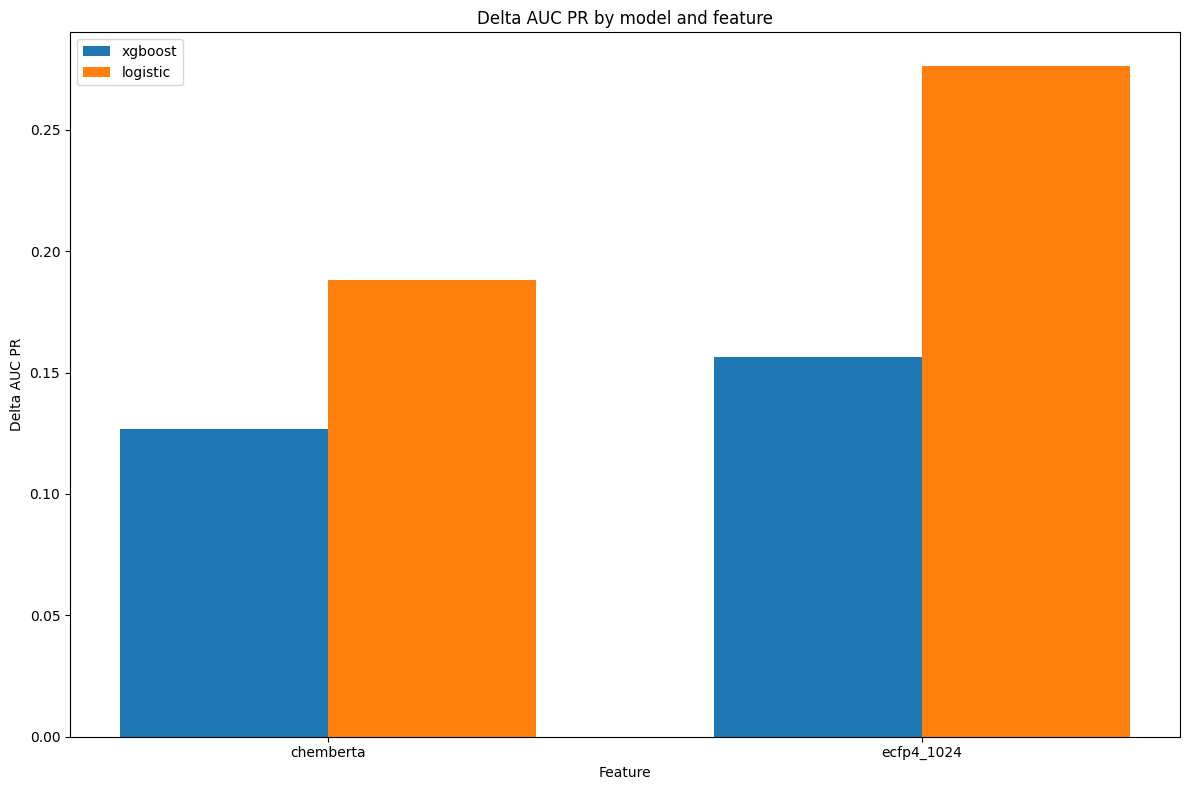

In [16]:
import numpy as np

features = df_final["feature"].unique().tolist()
models = df_final["model"].unique().tolist()
feature_width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(12, 8))

# Create an array of dataset indices for plot positioning
feature_indices = np.arange(len(features))

for idx, model in enumerate(models):
    model_data = df_final[df_final["model"] == model]
    median_values = [model_data[model_data["feature"] == feature]["delta_auc_pr"].median() for feature in features]
    rects = ax.bar(feature_indices - feature_width/2 + idx*feature_width, median_values, feature_width, label=model)

ax.set_xlabel('Feature')
ax.set_ylabel('Delta AUC PR')
ax.set_title('Delta AUC PR by model and feature')
ax.set_xticks(feature_indices)
ax.set_xticklabels(features)
ax.legend()

plt.tight_layout()
plt.show()

Again logistic regression outperforms XGBoost when using different features to train the models.

## Feature analysis
I am going to examine some feature importances for a few XGBoost and logistic regression models. I want to see the distributions of these feature importances for each model

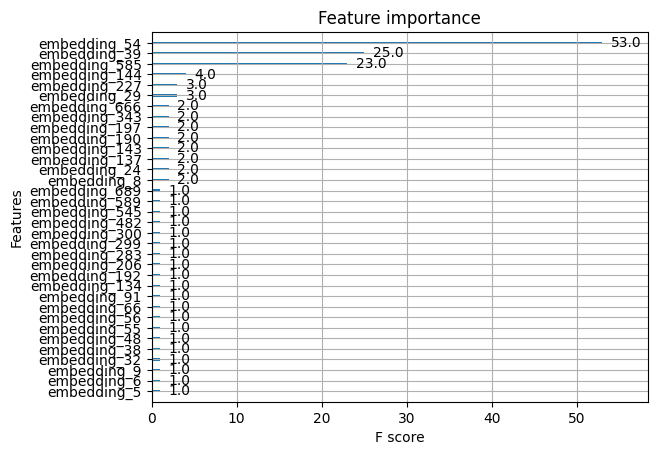

In [27]:
# Load models
with open("/Users/sethhowes/Desktop/FS-Tox/multirun/2023-08-01/14-26-16/params.feature=chemberta,params.model=logistic/data/processed/model/0d1cbb0140c60b6.pkl", 'rb') as file:
    log_reg = pickle.load(file)
    
with open("/Users/sethhowes/Desktop/FS-Tox/multirun/2023-08-01/14-26-16/params.feature=chemberta,params.model=xgboost/data/processed/model/0d1cbb0140c60b6.pkl", 'rb') as file:
    xgboost = pickle.load(file)

# Plot feature importance for XGBoost
plot_importance(xgboost)
plt.show()

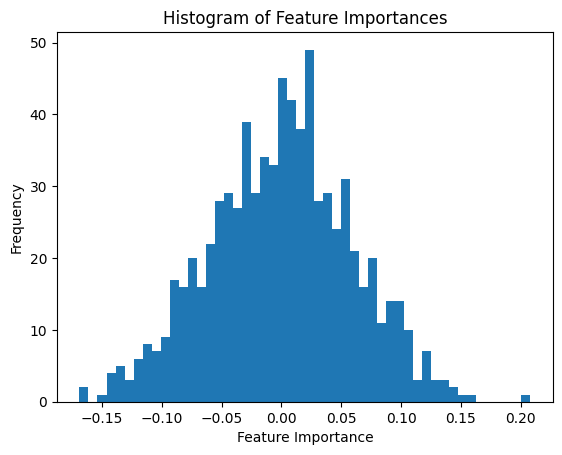

In [34]:
# Assuming importance_sorted is your array of sorted feature importances
plt.hist(importance_sorted, bins=50)
plt.xlabel('Feature Importance')
plt.ylabel('Frequency')
plt.title('Histogram of Feature Importances')
plt.show()

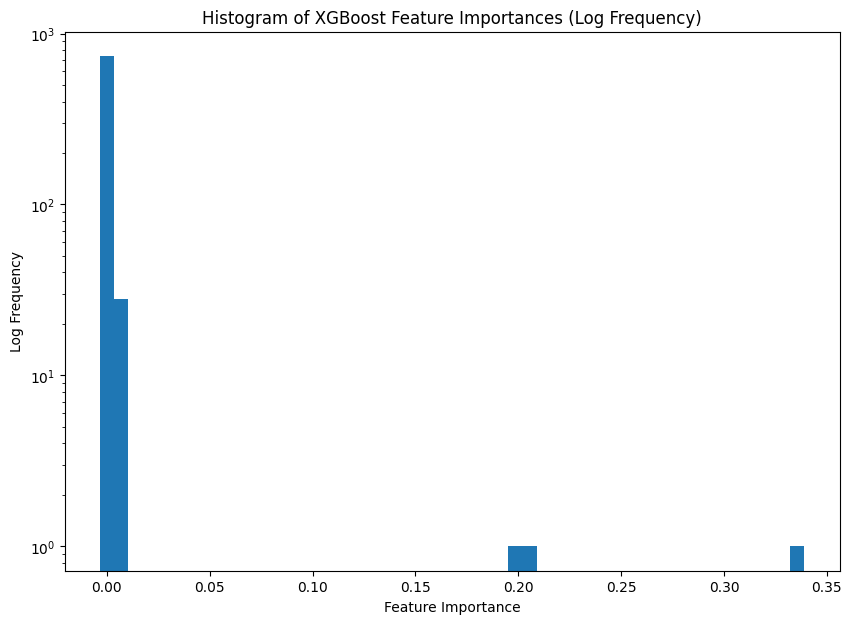

In [39]:
import numpy as np
import matplotlib.pyplot as plt

# Get feature importances
importances = xgboost.feature_importances_

# Calculate histogram with numpy
hist, bins = np.histogram(importances, bins=50)

# Plot histogram with log scale on y-axis
plt.figure(figsize=(10, 7))
plt.bar(bins[:-1], hist, width=(bins[1]-bins[0]))
plt.yscale('log', nonpositive='clip') # set yscale to 'log'
plt.xlabel('Feature Importance')
plt.ylabel('Log Frequency')
plt.title('Histogram of XGBoost Feature Importances (Log Frequency)')
plt.show()

Clearly there are a few features that are contributing to the classification of molecules for XGBoost, whilst there appears to be far more features that are contributing to the classification for logistic regression.